#### Model taken from:
- [1] Offshore Pipelaying Dynamics. Gullik Anthon Jensen 
- [2] A nonlinear PDE formulation for offshore vessel pipeline installation. Gullik A. Jensen et al 
- [3] Modeling and Control of Offshore Pipelay Operations Based on a Finite Strain Pipe Model. Gullik A. Jensen 

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.optimize import fsolve
from scipy.integrate import solve_ivp
from scipy import interpolate

In [2]:
import sys
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src/python_vehicle_simulator")
sys.path.insert(0, "../../../../Ocean_Intella/PythonVehicleSimulator-master/src")

In [3]:
from python_vehicle_simulator.vehicles import *
from python_vehicle_simulator.lib import *
from python_vehicle_simulator.lib.gnc import ssa

In [4]:
mp = 96       #  (submerged pipe weight) [kg/m]

In [5]:
node_N = 50

In [6]:
mi = [mp for i in range(node_N)] 

In [7]:
# L - the hull length
# Xg - x-center of gravity
L = 84.6 # [m]
B= 12
H= 13
Xg = L/2 # [m]
mn = 27_162_500 #123000000 # mass of the vessel, [kg]  
# kp, kd=1.95e4,1.5e4

In [8]:
lx,ly,lz=L/2,B/2,H/2

In [9]:
vessel_mass=mn/L # mass over length of the vessel

In [10]:
diag_Irho = 1e2*np.array([1, 1, 2]) # [m^4]  , p.99 in [1]
# diag_Irho = 1e-2*np.array([0.5, 0.5, 1])  # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Irho_=np.diag(diag_Irho)

In [11]:
Irho_

array([[100.,   0.,   0.],
       [  0., 100.,   0.],
       [  0.,   0., 200.]])

In [12]:
# Fossen book p.181
def vessel_inertia_moment(mn, Xg, L):
    r = 0.25*L
    Ir = mn*r**2
    Iz=mn*Xg**2 + Ir
    return Iz

In [13]:
vessel_inertia = vessel_inertia_moment(mn, Xg, L)

In [14]:
vessel_inertia

60751987031.24999

In [15]:
def inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws):
    V_rho=np.zeros(Irho_.shape)
    np.fill_diagonal(V_rho, vessel_inertia)
    cum_m=0
    cum_i=0
    fin_123=[]
    for i in range(node_N-1,-1,-1):
        cum_m+=Ws[i]*cum_d_inv[i]**2
        cum_i+=Irho_
        fin_123.append(V_rho+cum_m + cum_i)
    return np.array(fin_123[::-1])

In [16]:
lll = [100 for i in range(node_N)]

In [17]:
cum_d_inv=[10]
sum_=0
for i in range(len(lll)-1,-1,-1):
    sum_+=lll[i]
    cum_d_inv.append(sum_)
cum_d_inv=cum_d_inv[::-1]    

In [18]:
cum_d_inv

[5000,
 4900,
 4800,
 4700,
 4600,
 4500,
 4400,
 4300,
 4200,
 4100,
 4000,
 3900,
 3800,
 3700,
 3600,
 3500,
 3400,
 3300,
 3200,
 3100,
 3000,
 2900,
 2800,
 2700,
 2600,
 2500,
 2400,
 2300,
 2200,
 2100,
 2000,
 1900,
 1800,
 1700,
 1600,
 1500,
 1400,
 1300,
 1200,
 1100,
 1000,
 900,
 800,
 700,
 600,
 500,
 400,
 300,
 200,
 100,
 10]

In [19]:
Ws = np.array(mi)*9.81

In [20]:
Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
# Irho=np.array(fin_123)

In [21]:
# Irho+=vessel_inertia

In [22]:
Irho[-1][0][0]

60761404731.24999

In [23]:
Irho[-49][0][0]

441458471931.25

In [24]:
Irho

array([[[4.65002472e+11, 4.04250480e+11, 4.04250480e+11],
        [4.04250480e+11, 4.65002472e+11, 4.04250480e+11],
        [4.04250480e+11, 4.04250480e+11, 4.65002477e+11]],

       [[4.41458472e+11, 3.80706480e+11, 3.80706480e+11],
        [3.80706480e+11, 4.41458472e+11, 3.80706480e+11],
        [3.80706480e+11, 3.80706480e+11, 4.41458477e+11]],

       [[4.18846814e+11, 3.58094822e+11, 3.58094822e+11],
        [3.58094822e+11, 4.18846814e+11, 3.58094822e+11],
        [3.58094822e+11, 3.58094822e+11, 4.18846819e+11]],

       [[3.97148664e+11, 3.36396672e+11, 3.36396672e+11],
        [3.36396672e+11, 3.97148664e+11, 3.36396672e+11],
        [3.36396672e+11, 3.36396672e+11, 3.97148668e+11]],

       [[3.76345185e+11, 3.15593194e+11, 3.15593194e+11],
        [3.15593194e+11, 3.76345185e+11, 3.15593194e+11],
        [3.15593194e+11, 3.15593194e+11, 3.76345190e+11]],

       [[3.56417544e+11, 2.95665552e+11, 2.95665552e+11],
        [2.95665552e+11, 3.56417544e+11, 2.95665552e+11],
    

In [25]:
qw = 1025 # Water density [kg/m3]
d0 = 0.761 # Outer diameter of pipe, [m]
dI= 0.69 # Inner diameter of pipe, [m]

In [26]:
Ar=math.pi*((d0/2)**2-(dI/2)**2)

In [27]:
math.pi*(d0**4-dI**4)/64

0.005336285849082509

In [28]:
E = 210e9

In [29]:
E*Ar/1e10

1.6991625880187402

In [30]:
diag_DT = 1.5*np.array([1, 1, 1]) 

In [31]:
DT=np.diag(diag_DT) # (35) in [2]

In [32]:
DT

array([[1.5, 0. , 0. ],
       [0. , 1.5, 0. ],
       [0. , 0. , 1.5]])

In [33]:
# diag_CT = 1e9*np.array([1, 1, 1]) # [Nm2] p. 4721 in [3]
diag_CT = 1e10*np.array([1.7, 1.7, 1.7]) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

In [34]:
CT=np.diag(diag_CT)

In [35]:
CT

array([[1.7e+10, 0.0e+00, 0.0e+00],
       [0.0e+00, 1.7e+10, 0.0e+00],
       [0.0e+00, 0.0e+00, 1.7e+10]])

In [36]:
# angles should be in radians, otherwise np.radians them  
def Re_t_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
  
    Cφ=np.matrix([[1,0,0],
                      [0,np.cos(φ),-np.sin(φ)],
                      [0,np.sin(φ),np.cos(φ)]])

    Cθ=np.matrix([[np.cos(θ),0,np.sin(θ)],
                      [0,1,0],
                      [-np.sin(θ),0,np.cos(θ)]])

    Cψ=np.matrix([[np.cos(ψ),-np.sin(ψ),0],
                      [np.sin(ψ),np.cos(ψ),0],
                      [0,0,1]])
        

    return np.array(np.dot(np.dot(Cθ,Cφ),Cψ) )

In [37]:
Re_t_([1,2,3])

array([[ 0.51995985, -0.69876354,  0.4912955 ],
       [ 0.07624747, -0.53489523, -0.84147098],
       [ 0.85078086,  0.47499117, -0.2248451 ]])

In [38]:
rng = np.random.default_rng()

In [39]:
φ, θ, ψ = rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [40]:
def Re_t(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
    return np.apply_along_axis(Re_t_, 1, xyz)

In [41]:
Re_t_(np.array([φ[1], θ[1], ψ[1]]))

array([[ 0.50404378,  0.46322444,  0.72894649],
       [-0.85470655,  0.38886523,  0.34389031],
       [-0.12416355, -0.79637111,  0.59192606]])

In [42]:
startTime1 = datetime.now()
Ret=Re_t(φ,θ,ψ)
print(datetime.now() - startTime1)

0:00:00.009700


In [43]:
Ret.shape

(50, 3, 3)

In [44]:
dx,dy,dz=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [45]:
def C1(dx,dy,dz, Ret): # here
    B=np.vstack([np.abs(dx)*dx,(dy**2+dz**2)**0.5*dy,(dy**2+dz**2)**0.5*dz])
    ans=np.einsum('ijk,ik->ij', Ret, np.linalg.solve(Ret,B.T.astype(np.float64)))  
#     print(Ret[0].shape, B.T[0].shape)
#     print(np.linalg.solve(Ret[0],B.T[0].astype(np.float64)).shape)
#     ans=[]
#     for i in range(len(B.T)):
#         ans.append(np.dot(Ret[i],np.linalg.solve(Ret[i],B.T[i].astype(np.float64))))
#         print(ans[-1])
#     ans=np.tensordot(Ret, np.linalg.solve(Ret,B.T.astype(np.float64)),axes = 0)
    return np.array(ans).T

In [46]:
startTime1 = datetime.now()
C1(dx,dy,dz,Ret)
print(datetime.now() - startTime1)

0:00:00.000554


In [47]:
C1(dx,dy,dz,Ret)

array([[-1.17830030e+00,  1.58855175e-01,  3.31102505e-03,
        -4.73649315e-01,  4.14927170e+00, -1.47172551e+00,
        -7.25712308e-01,  9.61641446e-01, -1.82015622e+00,
        -1.73106838e+00,  1.52438871e+00, -1.26501510e+00,
        -1.25106492e+00,  2.92441464e-01, -4.31723352e+00,
        -3.77890235e-03,  1.25582257e+00,  2.13344029e-01,
        -3.47460056e-02, -1.20261398e-01,  3.36795849e+00,
        -1.33882175e+00, -4.97407723e-03,  2.59618897e+00,
        -6.03453231e-01, -2.45591847e+00,  2.33916320e-03,
         2.14550163e+00,  7.36930732e-01, -1.03262970e+00,
        -6.31923633e-01,  4.88577190e-01, -5.87134348e+00,
        -6.59918749e-02, -1.04837428e-01, -2.44961492e+00,
        -1.67158227e-02, -4.89087657e-01, -4.63097684e-01,
         5.17780144e-03,  2.68359085e+00,  2.99355641e-01,
         4.93392041e-02, -2.76111620e-01,  7.62372402e-01,
        -1.74478813e+00,  7.94252799e-01, -2.83863852e-04,
        -9.74044556e-01,  1.52835166e-01],
       [-7.24

In [48]:
def fD(dx,dy,dz,DT,Ret):
    return 1/2*d0*qw*np.dot(DT, C1(dx,dy,dz,Ret))*9.81

In [49]:
fD(dx,dy,dz,DT,Ret).T

array([[-6.76230541e+03, -4.16005564e+03,  1.73592132e+03],
       [ 9.11675239e+02,  9.63399279e+02, -1.91693831e+03],
       [ 1.90020851e+01, -5.56243217e+03, -4.09426843e+03],
       [-2.71828950e+03, -4.87163543e+03, -2.59355224e+03],
       [ 2.38128111e+04,  3.85605941e+03,  1.74377324e+03],
       [-8.44628262e+03, -1.04748801e+04,  9.98990144e+02],
       [-4.16488756e+03, -3.25140303e+02,  1.54409455e+03],
       [ 5.51889290e+03, -4.95954469e+02,  6.11419472e+03],
       [-1.04459383e+04, -1.67207293e+04, -8.18783216e+03],
       [-9.93466021e+03,  3.09711257e+03,  1.30170878e+03],
       [ 8.74851856e+03, -2.28242802e+03,  4.51631562e+03],
       [-7.25996458e+03, -7.03768280e+03,  9.85416389e+03],
       [-7.17990404e+03,  3.50962181e+04, -1.27962491e+04],
       [ 1.67833149e+03,  4.06300013e+04, -1.74068456e+04],
       [-2.47767497e+04, -2.25123705e+04, -2.63236958e+04],
       [-2.16872488e+01,  6.13164419e+03,  3.28055613e+03],
       [ 7.20720834e+03,  6.58328991e+02

In [50]:
startTime1 = datetime.now()
fD(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000419


In [51]:
# https://docs.scipy.org/doc/scipy-1.8.0/tutorial/integrate.html  
# 1-D Gray-Scott 

In [52]:
I=np.identity(3)

In [53]:
startTime1 = datetime.now()
np.dot(I,fD(dx,dy,dz,DT,Ret))
print(datetime.now() - startTime1)

0:00:00.000447


In [54]:
Rb_t=I # https://www.researchgate.net/profile/Thor-Fossen/publication/224560837_Modeling_and_Control_of_Offshore_Pipelay_Operations_Based_on_a_Finite_Strain_Pipe_Model/links/00b7d520e175a3f918000000/Modeling-and-Control-of-Offshore-Pipelay-Operations-Based-on-a-Finite-Strain-Pipe-Model.pdf

In [55]:
Rb_t

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [56]:
diag_DR = 1.5*np.array([1, 1, 1]) # [N m/rad]  p.4721 in [3]

In [57]:
DR=np.diag(diag_DR) 

In [58]:
Ar

0.08091250419136858

In [59]:
fg_e=np.array([[0,0,(mp-qw*Ar)*9.81] for x in range(node_N)])

In [60]:
fg_e

array([[  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.        , 128.16454223],
       [  0.        ,   0.     

In [61]:
x,y,z=rng.standard_normal(node_N),rng.standard_normal(node_N),rng.standard_normal(node_N)

In [62]:
def Re_b(Ret):
    return Ret

In [63]:
startTime1 = datetime.now()
Re_b(Ret)
print(datetime.now() - startTime1)

0:00:00.000081


In [64]:
def phi(x, y, z, Ret,dummy,dummy1): # here
    B=np.vstack([x,y,z])
    return np.linalg.solve(Ret.astype(np.float64),B.T.astype(np.float64))
#     return np.einsum('ijk,ik->ij', Ret,B.T.astype(np.float64))

In [65]:
phi(x,y,z,Ret,None,None)

array([[ 0.96154293,  0.17969352, -0.6474163 ],
       [ 0.25706501, -0.21224132, -0.18868864],
       [ 0.71266049, -0.59989508,  1.05021799],
       [ 0.60253446,  1.27469336,  0.1828363 ],
       [ 0.42114576, -0.27383655, -1.45590731],
       [ 1.12096564, -0.50278025,  1.77151215],
       [-0.88192202,  0.62389835, -0.35591664],
       [ 0.36291604, -1.97135096,  0.97842631],
       [-1.01439286,  2.63632115, -0.47442771],
       [-1.62208824,  1.64530165, -0.93516262],
       [-0.11601281, -1.06841739,  0.01574611],
       [-0.50783396,  1.27614354, -0.89532686],
       [ 0.84378022,  0.1838549 ,  0.62612813],
       [ 0.84565965,  1.1971699 ,  1.00668884],
       [ 0.91021485,  0.91485893,  0.33518226],
       [-0.18145868,  0.60145725,  1.11594765],
       [ 0.76526008,  0.06681956,  0.92301025],
       [-2.49374774, -1.30989744, -0.15428659],
       [ 0.18011351, -0.72507986, -1.08677866],
       [ 0.87515021,  1.53650648, -1.37899356],
       [-1.5050043 ,  1.0714084 , -0.195

In [66]:
startTime1 = datetime.now()
phi(x,y,z,Ret,None,None)
print(datetime.now() - startTime1)

0:00:00.000524


In [67]:
def Π_(arr):
    φ,θ,ψ=arr[0],arr[1],arr[2]
    return np.array([[np.cos(θ),0,np.cos(φ)*np.sin(θ)],
                  [0,1,-np.sin(φ)],
                  [-np.sin(θ),0,np.cos(φ)*np.cos(θ)]])

In [68]:
def Π(a,b,c):
    xyz=np.stack((a,b,c), axis=1)
  
    return np.apply_along_axis(Π_, 1, xyz)
    

In [69]:
startTime1 = datetime.now()
Π(φ,θ,ψ).shape
print(datetime.now() - startTime1)

0:00:00.001560


In [70]:
def ωe(φ,θ,ψ, dummy,dummy1,dummy2): # here # (100) in [2]
    A=Π(φ,θ,ψ)
    B=np.vstack([φ,θ,ψ])
    return np.einsum('ijk,ik->ij',A,B.T.astype(np.float64))

In [71]:
startTime1 = datetime.now()
ωe(φ,θ,ψ,None,None,None)
print(datetime.now() - startTime1)

0:00:00.001989


In [72]:
ωe(φ,θ,ψ,None,None,None)

array([[-1.34524997e+00, -1.09806803e+00, -2.09068038e-01],
       [-1.05507841e+00,  4.95415435e-01, -4.04532651e-01],
       [-1.78704996e+00, -1.27473671e+00, -1.14342162e+00],
       [-1.24081200e+00, -5.18351124e-01,  1.88740462e-01],
       [-8.58332263e-01, -6.91296618e-01, -2.73733180e-01],
       [-4.35217387e-01, -4.21826538e-01, -1.17433101e+00],
       [-3.11522966e-01,  9.58013248e-01,  1.06892460e-01],
       [ 4.83690910e-01, -2.03171719e+00, -4.33504787e-01],
       [-9.66851887e-01, -1.50944334e-01,  1.06043360e+00],
       [-2.77904174e-01, -9.08571745e-01,  2.49803343e-03],
       [-6.09307009e-01,  1.78003928e+00,  1.64850532e-01],
       [-1.54527981e+00, -4.55316451e-01, -1.68113545e-01],
       [-6.89732577e-01,  5.32496718e-01, -1.25592287e+00],
       [-2.87922588e-02,  3.57573598e-01, -3.51816652e-01],
       [ 1.31542424e+00,  5.58146439e-01, -9.82235410e-02],
       [ 3.29243934e-01,  6.63213548e-01,  2.94209966e-01],
       [ 3.14631830e-01, -1.77962498e+00

In [73]:
def d_s(f,a,b,c,Ret,omega): # here
    
    fun = f(a,b,c,Ret,omega, None) 
    
#     if flag==1:
#         fun+=-np.dot(Ret,force)
# #         fun*=-np.dot(Ret,force)
#     elif flag==2:
#         fun+=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#         fun*=-np.dot(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)),force)
#     print(np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),Re_b(Ret)))
#     print(np.dot(np.linalg.inv(Π(φ,θ,ψ).astype(np.float64))[2],Re_b(Ret)[2]))
        
# #     print(fun)
#     if any(force):
# #         fun[-1]=-np.array(force)
#         fun[-1]=-np.dot(Ret[-1],force)
# #         fun+=-np.dot(Ret,force) # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# #     print(fun)

    def S(arr):
        a1,a2,a3=arr[0],arr[1],arr[2]
        return np.array([[0, -a3, a2 ],
                         [a3, 0, -a1],
                        [-a2, a1, 0]])
    K=np.apply_along_axis(S, 1, omega)
    
    
   
    return np.einsum('ijk,ik->ij',K, fun.astype(np.float64)).T

In [74]:
φ, θ, ψ = np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)]),np.array([0.00001 for i in range(node_N)])

In [75]:
d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None))

array([[-8.27101543e-06,  2.35524451e-07,  1.65009656e-05,
        -1.09184614e-05, -1.18205895e-05,  2.27426966e-05,
        -9.79805197e-06,  2.94974777e-05, -3.11071776e-05,
        -2.58043846e-05,  1.08415266e-05, -2.17144868e-05,
         4.42268809e-06, -1.90479155e-06, -5.79670874e-06,
         5.14485256e-06,  8.56182129e-06,  1.15559930e-05,
        -3.61695185e-06, -2.91547089e-05, -1.26706183e-05,
         1.94058069e-05,  2.79899916e-06,  2.06073118e-06,
         5.23038257e-06,  1.80737725e-06,  8.75599588e-07,
        -7.37194672e-06,  3.11040079e-06, -2.46029458e-06,
         1.83270793e-05, -3.15511252e-05, -3.04892151e-05,
         4.90660261e-06,  2.91380879e-07, -1.02536712e-06,
        -4.82078695e-06, -1.20329889e-05,  6.43361626e-06,
        -9.72502698e-06, -3.21635881e-05,  4.85796756e-06,
         4.60415486e-06, -7.87624974e-06, -9.87313270e-06,
         1.44431189e-05, -1.27029067e-05, -5.41618983e-06,
         1.49618814e-05, -1.81171348e-05],
       [ 1.60

In [76]:
startTime1 = datetime.now()
d_s(phi,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.001631


In [77]:
def ne(x,y,z,Ret,omega,force): # here
    A=np.multiply(np.multiply(Ret,CT),Ret)
    B=d_s(phi,x,y,z,Ret,omega).T
    return np.einsum('ijk,ik->ij', A.astype(np.float64),B
                     -
                     np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()
                    )

In [78]:
# np.dot(Ret.astype(np.float64)[2],np.array([1,0,0]).reshape(3,1)).squeeze()

In [79]:
# np.einsum('ijk,kp->ijp',Ret.astype(np.float64), np.array([1,0,0]).reshape(3,1)).squeeze()

In [80]:
φ, θ, ψ = np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)]),np.array([0.000001 for i in range(node_N)])

In [81]:
d_s(ωe,x,y,z,Ret,ωe(φ,θ,ψ,None,None,None))

array([[-1.43668314e-06,  3.49876318e-07, -1.28902404e-06,
        -1.27932772e-06,  1.54246183e-06,  2.18374150e-06,
        -2.24608523e-07,  5.76077787e-07, -5.82593298e-07,
        -1.38826039e-06,  1.54923482e-06, -7.74069081e-08,
        -1.73122822e-06, -1.09571970e-06, -2.56841170e-08,
         8.79295315e-07, -7.98157895e-08,  2.60113955e-07,
         1.46312083e-07, -7.08099439e-07, -8.91017608e-07,
        -3.13079309e-06,  8.73961592e-07,  2.42322358e-07,
         8.70062776e-07,  3.17447843e-07,  1.62958209e-06,
         4.94710392e-07,  9.96087933e-08,  2.99764684e-06,
        -4.32863249e-06, -2.56249443e-06, -7.87427596e-07,
         1.09326469e-07, -2.26088487e-06, -3.56988461e-07,
        -7.21235069e-07,  3.00694520e-06, -7.59513922e-07,
         8.35829093e-07,  3.33344422e-06, -2.10736371e-07,
        -5.23090516e-07,  4.61003983e-07, -1.25223345e-06,
         3.09903659e-06,  8.20931784e-08, -3.51247005e-07,
        -9.92473503e-07, -1.90615132e-06],
       [ 1.27

In [82]:
def ne_(dx,dy,dz,DT,Ret):
    return -fg_e.T-fD(dx,dy,dz,DT,Ret) #-sigma(x,y,z).T

In [83]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.76230541e+03, -9.11675239e+02, -1.90020851e+01,
         2.71828950e+03, -2.38128111e+04,  8.44628262e+03,
         4.16488756e+03, -5.51889290e+03,  1.04459383e+04,
         9.93466021e+03, -8.74851856e+03,  7.25996458e+03,
         7.17990404e+03, -1.67833149e+03,  2.47767497e+04,
         2.16872488e+01, -7.20720834e+03, -1.22438862e+03,
         1.99408505e+02,  6.90184245e+02, -1.93288281e+04,
         7.68354349e+03,  2.85463981e+01, -1.48996166e+04,
         3.46323857e+03,  1.40945994e+04, -1.34245370e+01,
        -1.23131066e+04, -4.22927048e+03,  5.92629690e+03,
         3.62663117e+03, -2.80396108e+03,  3.36958395e+04,
         3.78729609e+02,  6.01665558e+02,  1.40584231e+04,
         9.59326739e+01,  2.80689066e+03,  2.65773332e+03,
        -2.97155782e+01, -1.54012190e+04, -1.71801218e+03,
        -2.83159367e+02,  1.58461396e+03, -4.37528109e+03,
         1.00133983e+04, -4.55824377e+03,  1.62910428e+00,
         5.59007477e+03, -8.77126206e+02],
       [ 4.16

In [84]:
startTime1 = datetime.now()
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[0,0,1])
print(datetime.now() - startTime1)

0:00:00.004724


In [85]:
d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T

array([[ 4.64522415e+02, -4.44762128e+02, -1.97612160e+01],
       [-1.45760738e+03, -2.91653969e+03,  4.37414999e+03],
       [-1.39129933e+03,  1.91576899e+03, -5.24466879e+02],
       [-1.11051110e+03, -7.79314113e+03,  8.90365445e+03],
       [ 2.39156442e+03, -3.88501523e+03,  1.49344603e+03],
       [-6.00297444e+03,  4.49752390e+03,  1.50546255e+03],
       [ 4.46566489e+02, -6.61618919e+03,  6.16962181e+03],
       [-4.29517378e+03,  1.90729334e+03,  2.38788904e+03],
       [-2.82180783e+01, -1.59459588e+04,  1.59741769e+04],
       [-8.31001418e+02,  6.95914239e+02,  1.35088841e+02],
       [-5.86474473e+03, -5.90359159e+02,  6.45511562e+03],
       [-2.01354864e+00, -1.23129494e+04,  1.23149629e+04],
       [ 2.68230310e+01, -9.83784916e+03,  9.81102607e+03],
       [-1.87406101e+01, -1.66666932e+04,  1.66854338e+04],
       [ 3.50486735e+02, -2.33451738e+03,  1.98402995e+03],
       [ 1.14564823e+04, -1.18042561e+04,  3.47750875e+02],
       [-7.05772093e+03,  1.88589550e+03

In [86]:
ne(x,y,z,Ret,ωe(φ,θ,ψ,None,None,None),[1,23,4])

array([[-4.55604318e+08, -4.75364603e+08, -1.08417231e+07],
       [-2.17697618e+09,  2.19717379e+09,  7.39564952e+08],
       [-3.03278574e+08, -8.27744322e+08, -2.21904505e+09],
       [-8.72616771e+09,  1.77495289e+08, -9.33016920e+08],
       [-4.76896399e+09, -3.27550991e+09, -8.83943101e+08],
       [-4.57945068e+08,  1.04751690e+09, -4.95546355e+09],
       [-3.04100703e+09,  3.12861470e+09,  3.57518163e+09],
       [ 1.29945304e+09,  3.68733709e+09, -6.07840993e+08],
       [-1.59650275e+10,  9.16533158e+06, -1.90527750e+07],
       [-3.66529454e+09, -3.53019850e+09, -4.36120075e+09],
       [ 7.74916151e+07,  6.53260062e+09,  6.67850029e+08],
       [-1.23149525e+10,  2.27587457e+04, -1.99079190e+06],
       [-9.81785746e+09, -6.82156604e+06,  2.00014918e+07],
       [-1.16645716e+10,  5.02086884e+09,  5.00212821e+09],
       [-2.32096822e+09, -3.36935614e+08,  1.35514708e+07],
       [-6.21958531e+09, -5.87182235e+09,  5.58467139e+09],
       [ 8.71602368e+07,  5.25899443e+09

In [87]:
startTime1 = datetime.now()
ne_(dx,dy,dz,DT,Ret)
print(datetime.now() - startTime1)

0:00:00.000397


In [88]:
Re_b(Ret).shape

(50, 3, 3)

In [89]:
# def Irho_e(Ret):
    
#     ans1 = np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
    
#     sum_=np.zeros(Irho.shape)
# #     print(sum_)
    
#     for i in range(len(ans1)):
#         sum_+=ans1[i]
#         ans1[i]=sum_
        
#     tmp=np.zeros(Irho.shape)
#     np.fill_diagonal(tmp, vessel_inertia)
    
#     ans2=np.multiply(np.multiply(Ret,tmp),Ret)
#     ans1[-1]+=ans2[-1]
    
#     for i in range(int(node_N/4)):
#         ans1[i]*=(10-i+1)
#     return ans1
def Irho_e(Ret,Irho): # here
#     ans= np.multiply(np.multiply(Ret,Irho),Ret) # (19) in [3] 
#     print(Irho[1])
#     print(np.dot(np.dot(Ret[1],Irho[1]),Ret[1]))
    ans=  np.einsum('ijk,ikp->ijp', np.einsum('ijk,ikp->ijp', Ret,Irho),Ret)
    return ans

In [90]:
Irho_e(Ret,Irho)

array([[[-3.82207620e+11,  2.79045043e+11,  1.40100112e+11],
        [ 8.25809762e+11, -4.84985278e+11, -3.90346848e+11],
        [-4.83662655e+11,  2.39474119e+11,  1.57464920e+11]],

       [[-3.20740716e+11,  2.58416272e+10,  1.13324982e+12],
        [-2.69134241e+10, -3.40909828e+10, -9.46507620e+10],
        [ 9.24869663e+10, -5.79165640e+10, -2.09117843e+11]],

       [[ 8.33168420e+11,  1.92169051e+11,  4.85158521e+11],
        [ 4.49003999e+11,  1.22623568e+11,  1.88539081e+11],
        [ 2.10371187e+11,  1.12407781e+11,  1.41888565e+11]],

       [[ 5.42338388e+11,  3.68648841e+09,  7.84632143e+11],
        [ 2.68412662e+11, -6.58031622e+10,  4.02248049e+11],
        [ 6.22370217e+10, -7.61061783e+09, -1.59724993e+10]],

       [[-1.55365715e+10,  4.45141229e+10, -4.53592479e+10],
        [ 9.97027160e+11, -1.14899890e+11,  8.38641052e+10],
        [-1.65159823e+10, -4.18533369e+10, -4.35696870e+10]],

       [[-1.43042423e+11,  4.40875542e+11,  5.40411454e+11],
        [-3.22

In [91]:
startTime1 = datetime.now()
Irho_e(Ret,Irho)
print(datetime.now() - startTime1)

0:00:00.003640


In [92]:
79.3*1e9*math.pi*(d0**4-dI**4)/64

423167467.8322429

In [93]:
# diag_CR = 1e11*np.array([1, 1, 1])
diag_CR = 1e9*np.array([4, 4, 4]) #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

CR=np.diag(diag_CR)

In [94]:
CR

array([[4.e+09, 0.e+00, 0.e+00],
       [0.e+00, 4.e+09, 0.e+00],
       [0.e+00, 0.e+00, 4.e+09]])

In [95]:
def d_me(φ,θ,ψ,Ret,fun,omega):
    A=np.multiply(np.multiply(Ret,CR),Ret)
    B=d_s(fun,φ,θ,ψ,Ret.astype(np.float32),omega.astype(np.float32))

    return np.einsum('ijk,ik->ij', A,B.T.astype(np.float32)) 

In [96]:
startTime1 = datetime.now()
d_me_=d_me(φ,θ,ψ,Ret,ωe, ωe(φ,θ,ψ,None,None,None))
print(datetime.now() - startTime1)

0:00:00.002534


In [97]:
d_me_

array([[-3.58238974e-16, -5.51379084e-12,  7.34687342e-13],
       [-1.01628975e-15, -2.80430898e-11,  6.49788332e-11],
       [-2.73114481e-16, -3.01014086e-11,  2.63854759e-11],
       [-2.56446664e-15, -5.98534171e-12,  2.01854311e-11],
       [-1.71420958e-15, -5.95182240e-11,  2.09907786e-11],
       [-3.59467419e-16, -1.28077969e-11,  1.60036684e-10],
       [-1.26996823e-15, -1.65717949e-10,  4.87482235e-11],
       [-7.20477006e-16, -1.13620771e-10,  7.95652415e-12],
       [-3.83613551e-15, -7.76338185e-13,  1.32993340e-12],
       [-1.43831194e-15, -1.71334334e-10,  6.19440613e-11],
       [-1.09972220e-16, -1.20845160e-10,  9.21749026e-12],
       [-3.22653370e-15, -4.40379618e-14,  4.93874727e-14],
       [-2.77412727e-15, -4.46003460e-13,  4.13343725e-13],
       [-3.11191371e-15, -1.63187854e-10,  1.64975666e-10],
       [-1.06062261e-15, -4.28800700e-12,  1.44249371e-11],
       [-2.04623844e-15, -1.51495313e-10,  1.09476281e-10],
       [-1.18939445e-16, -1.26037952e-10

In [98]:
# diag_DR = 1.5*np.array([1, 1, 1]) 
 
# DR=np.diag(diag_DR)

In [99]:
ne_(dx,dy,dz,DT,Ret)

array([[ 6.76230541e+03, -9.11675239e+02, -1.90020851e+01,
         2.71828950e+03, -2.38128111e+04,  8.44628262e+03,
         4.16488756e+03, -5.51889290e+03,  1.04459383e+04,
         9.93466021e+03, -8.74851856e+03,  7.25996458e+03,
         7.17990404e+03, -1.67833149e+03,  2.47767497e+04,
         2.16872488e+01, -7.20720834e+03, -1.22438862e+03,
         1.99408505e+02,  6.90184245e+02, -1.93288281e+04,
         7.68354349e+03,  2.85463981e+01, -1.48996166e+04,
         3.46323857e+03,  1.40945994e+04, -1.34245370e+01,
        -1.23131066e+04, -4.22927048e+03,  5.92629690e+03,
         3.62663117e+03, -2.80396108e+03,  3.36958395e+04,
         3.78729609e+02,  6.01665558e+02,  1.40584231e+04,
         9.59326739e+01,  2.80689066e+03,  2.65773332e+03,
        -2.97155782e+01, -1.54012190e+04, -1.71801218e+03,
        -2.83159367e+02,  1.58461396e+03, -4.37528109e+03,
         1.00133983e+04, -4.55824377e+03,  1.62910428e+00,
         5.59007477e+03, -8.77126206e+02],
       [ 4.16

### Static solution

In [100]:
def catenary(x,Ws,Fh):
    return (Fh/Ws)*(np.cosh(x*Ws/Fh)-1)

In [101]:
pipe_weight_per_unit_length = mi #  (submerged) [kg/m]  # 113.07 - not submerged

In [102]:
Fx_0=82945396

In [103]:
Ws = np.array(pipe_weight_per_unit_length)*9.81 # [N/m]
h=700

In [104]:
S=math.sqrt(h*(2*Fx_0/Ws[0] -h))
horizontal_length=(Fx_0/Ws[0] -h)*np.log((S+Fx_0/Ws[0])/(Fx_0/Ws[0]-h))

In [105]:
Ws

array([941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76, 941.76,
       941.76, 941.76])

In [106]:
delta_x=horizontal_length/(node_N-1)

In [107]:
x0=[i*delta_x for i in range(node_N)]
z0=[]

for i in range(len(x0)):
    z0.append(catenary(x0[i],Ws[0],Fx_0))

length_p=[]
for i in range(1,len(z0)):
    length_p.append(math.sqrt((x0[i]-x0[i-1])**2+(z0[i]-z0[i-1])**2))

In [108]:
M_totl=[]
v_mass=vessel_mass*9.81
for i in range(node_N):
    v_mass+=Ws[i]
    M_totl.append(v_mass)
M_totl=np.array(M_totl[::-1])

In [109]:
M_totl

array([3196782.14893616, 3195840.38893616, 3194898.62893616,
       3193956.86893616, 3193015.10893616, 3192073.34893616,
       3191131.58893616, 3190189.82893616, 3189248.06893616,
       3188306.30893616, 3187364.54893616, 3186422.78893616,
       3185481.02893616, 3184539.26893616, 3183597.50893616,
       3182655.74893616, 3181713.98893616, 3180772.22893616,
       3179830.46893616, 3178888.70893616, 3177946.94893616,
       3177005.18893616, 3176063.42893616, 3175121.66893616,
       3174179.90893616, 3173238.14893617, 3172296.38893617,
       3171354.62893617, 3170412.86893617, 3169471.10893617,
       3168529.34893617, 3167587.58893617, 3166645.82893617,
       3165704.06893617, 3164762.30893617, 3163820.54893617,
       3162878.78893617, 3161937.02893617, 3160995.26893617,
       3160053.50893617, 3159111.74893617, 3158169.98893617,
       3157228.22893617, 3156286.46893617, 3155344.70893617,
       3154402.94893617, 3153461.18893617, 3152519.42893617,
       3151577.66893617,

In [110]:
x0,z0

([0.0,
  225.56499682574736,
  451.1299936514947,
  676.6949904772421,
  902.2599873029894,
  1127.8249841287368,
  1353.3899809544841,
  1578.9549777802315,
  1804.5199746059789,
  2030.0849714317262,
  2255.6499682574736,
  2481.2149650832207,
  2706.7799619089683,
  2932.344958734716,
  3157.909955560463,
  3383.47495238621,
  3609.0399492119577,
  3834.6049460377053,
  4060.1699428634524,
  4285.7349396892,
  4511.299936514947,
  4736.864933340695,
  4962.429930166441,
  5187.994926992189,
  5413.559923817937,
  5639.124920643684,
  5864.689917469432,
  6090.254914295178,
  6315.819911120926,
  6541.384907946674,
  6766.94990477242,
  6992.514901598168,
  7218.079898423915,
  7443.644895249663,
  7669.209892075411,
  7894.774888901157,
  8120.339885726905,
  8345.904882552652,
  8571.4698793784,
  8797.034876204147,
  9022.599873029894,
  9248.164869855642,
  9473.72986668139,
  9699.294863507137,
  9924.859860332883,
  10150.42485715863,
  10375.989853984378,
  10601.554850810126,

In [111]:
length_p

[225.56518176169666,
 225.56666125111053,
 225.5696202396424,
 225.57405874670005,
 225.57997680139619,
 225.58737444254686,
 225.59625171867356,
 225.60660868800304,
 225.61844541846622,
 225.63176198770017,
 225.64655848304906,
 225.66283500156428,
 225.6805916500017,
 225.69982854482856,
 225.72054581222017,
 225.74274358806272,
 225.76642201794883,
 225.79158125718783,
 225.81822147079842,
 225.84634283351636,
 225.8759455297893,
 225.90702975377832,
 225.93959570937227,
 225.97364361016668,
 226.00917367948318,
 226.04618615036563,
 226.08468126557727,
 226.1246592776104,
 226.1661204486828,
 226.20906505073324,
 226.25349336544267,
 226.29940568421313,
 226.34680230818745,
 226.39568354823808,
 226.4460497249786,
 226.49790116876304,
 226.55123821968485,
 226.60606122758307,
 226.6623705520452,
 226.72016656240044,
 226.77944963773572,
 226.84022016689133,
 226.90247854846268,
 226.96622519079838,
 227.03146051202393,
 227.0981849400066,
 227.16639891240425,
 227.2361028766249,
 

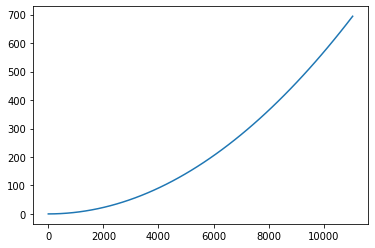

In [112]:
plt.plot(x0, z0)
plt.show()

In [113]:
rng = np.random.default_rng(seed=29)
q0=np.zeros(12*node_N)

In [114]:
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0

In [115]:
def static_func(Q): # here
    t=0
 
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
    Ret = Re_t(φ,θ,ψ)

    
    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
    η=[x[-1],y[-1],z[-1],φ[-1],θ[-1],ψ[-1]]
    
    tau_force=np.array([-Fx_0,0,0,0,0,0])
    Z0=np.dot(Re_b(Ret),tau_force[:3])
    Z1 = d_s(ne, x, y, z, Ret, ωe(φ,θ,ψ,None,None,None)).T
#     test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)

#     Z1 = d_s(ne, x, y, z, Ret, test).T
    DT_0=np.zeros((3,3))
    Z2=ne_(dx,dy,dz,DT_0,Ret).T
    
    
    Z =  Z1 + Z2 + Z0
    
    
############################################################ 
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',M_totl,Re_b(Ret)),Z).T
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T

############################################################ 

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1] 
     
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
    
    
    C0=np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    C3=d_me(φ,θ,ψ,Ret,  ωe,ωe(φ,θ,ψ,None,None,None))
  
    B_ =C3
    B=(B_ + C0.squeeze()
      )

    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)
    A=np.einsum('ijk,ikr->ijr',A2,A3)


#############################################
    ddφ,ddθ,ddψ = np.linalg.solve(A,B).T
#############################################

    ans=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
  
 
    return ans  

In [116]:
q0

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [117]:
root = fsolve(static_func, q0)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/optimize/minpack.py:175: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [118]:
root

array([0.00000000e+00, 2.25564997e+02, 4.51129994e+02, 6.76694990e+02,
       9.02259987e+02, 1.12782498e+03, 1.35338998e+03, 1.57895498e+03,
       1.80451997e+03, 2.03008497e+03, 2.25564997e+03, 2.48121497e+03,
       2.70677996e+03, 2.93234496e+03, 3.15790996e+03, 3.38347495e+03,
       3.60903995e+03, 3.83460495e+03, 4.06016994e+03, 4.28573494e+03,
       4.51129994e+03, 4.73686493e+03, 4.96242993e+03, 5.18799493e+03,
       5.41355992e+03, 5.63912492e+03, 5.86468992e+03, 6.09025491e+03,
       6.31581991e+03, 6.54138491e+03, 6.76694990e+03, 6.99251490e+03,
       7.21807990e+03, 7.44364490e+03, 7.66920989e+03, 7.89477489e+03,
       8.12033989e+03, 8.34590488e+03, 8.57146988e+03, 8.79703488e+03,
       9.02259987e+03, 9.24816487e+03, 9.47372987e+03, 9.69929486e+03,
       9.92485986e+03, 1.01504249e+04, 1.03759899e+04, 1.06015549e+04,
       1.08271198e+04, 1.10526848e+04, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [119]:
x0_,z0_=root[:node_N],root[4*node_N:5*node_N]

In [120]:
x0

[0.0,
 225.56499682574736,
 451.1299936514947,
 676.6949904772421,
 902.2599873029894,
 1127.8249841287368,
 1353.3899809544841,
 1578.9549777802315,
 1804.5199746059789,
 2030.0849714317262,
 2255.6499682574736,
 2481.2149650832207,
 2706.7799619089683,
 2932.344958734716,
 3157.909955560463,
 3383.47495238621,
 3609.0399492119577,
 3834.6049460377053,
 4060.1699428634524,
 4285.7349396892,
 4511.299936514947,
 4736.864933340695,
 4962.429930166441,
 5187.994926992189,
 5413.559923817937,
 5639.124920643684,
 5864.689917469432,
 6090.254914295178,
 6315.819911120926,
 6541.384907946674,
 6766.94990477242,
 6992.514901598168,
 7218.079898423915,
 7443.644895249663,
 7669.209892075411,
 7894.774888901157,
 8120.339885726905,
 8345.904882552652,
 8571.4698793784,
 8797.034876204147,
 9022.599873029894,
 9248.164869855642,
 9473.72986668139,
 9699.294863507137,
 9924.859860332883,
 10150.42485715863,
 10375.989853984378,
 10601.554850810126,
 10827.119847635873,
 11052.68484446162]

In [121]:
x0_

array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
         902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
        1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
        2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
        3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
        4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
        5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
        6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
        7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
        8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
        9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
        9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
       10827.11984764, 11052.68484446])

In [122]:
z0

[0.0,
 0.2888428427924309,
 1.155373265710624,
 2.5995969523577234,
 4.621523375418674,
 7.221165796797117,
 10.398541267595833,
 14.15367062831231,
 18.486578508975636,
 23.39729332924428,
 28.885847298621222,
 34.95227641670818,
 41.59662047340119,
 48.81892304912524,
 56.619231515186364,
 64.99759703402582,
 73.9540745596112,
 83.48872283771031,
 93.60160440638002,
 104.29278559627915,
 115.56233653119654,
 127.41033112846175,
 139.83684709937523,
 152.8419659498538,
 166.4257729808412,
 180.58835728891447,
 195.3298117668901,
 210.65023310439128,
 226.54972178849314,
 243.02838210444648,
 260.0863221362252,
 277.72365376736735,
 295.94049268164,
 314.7369583638412,
 334.1131741005232,
 354.0692669808534,
 374.60536789741576,
 395.72161154711085,
 417.41813643197673,
 439.6950848601867,
 462.5526029468705,
 485.9908406151509,
 510.0099515971214,
 534.6100934348437,
 559.7914274813454,
 585.5541189017534,
 611.8983366742727,
 638.8242535914375,
 666.3320462610891,
 694.4218951076863]

In [123]:
z0_

array([0.00000000e+00, 2.88842843e-01, 1.15537327e+00, 2.59959695e+00,
       4.62152338e+00, 7.22116580e+00, 1.03985413e+01, 1.41536706e+01,
       1.84865785e+01, 2.33972933e+01, 2.88858473e+01, 3.49522764e+01,
       4.15966205e+01, 4.88189230e+01, 5.66192315e+01, 6.49975970e+01,
       7.39540746e+01, 8.34887228e+01, 9.36016044e+01, 1.04292786e+02,
       1.15562337e+02, 1.27410331e+02, 1.39836847e+02, 1.52841966e+02,
       1.66425773e+02, 1.80588357e+02, 1.95329812e+02, 2.10650233e+02,
       2.26549722e+02, 2.43028382e+02, 2.60086322e+02, 2.77723654e+02,
       2.95940493e+02, 3.14736958e+02, 3.34113174e+02, 3.54069267e+02,
       3.74605368e+02, 3.95721612e+02, 4.17418136e+02, 4.39695085e+02,
       4.62552603e+02, 4.85990841e+02, 5.10009952e+02, 5.34610093e+02,
       5.59791427e+02, 5.85554119e+02, 6.11898337e+02, 6.38824254e+02,
       6.66332046e+02, 6.94421895e+02])

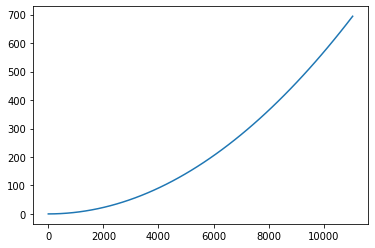

In [124]:
plt.plot(x0_, z0_)
plt.show()

In [125]:
init=1
for j in range(1,12):
    if j==1:  
        q0[(j-1)*node_N:j*node_N]=x0_
    elif j==5:    
        q0[(j-1)*node_N:j*node_N]=z0_
#     elif j==9:    
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
#     elif j==11:   
#         q0[(j-1)*node_N:j*node_N]=init*rng.standard_normal(node_N)
#         q0[(j-1)*node_N]=0
    elif j==7:    
        q0[(j-1)*node_N:j*node_N]=np.array([-0.0022313638346709297*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==9:    
        q0[(j-1)*node_N:j*node_N]=np.array([1.3587337935216937e-05*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0
    elif j==11:   
        q0[(j-1)*node_N:j*node_N]=np.array([0.013664356620045393*(i+1)/node_N*init for i in range(node_N)])
#         q0[(j-1)*node_N]=0 
# q0[9*node_N-1]=0.13  # here

In [126]:
q0

array([ 0.00000000e+00,  2.25564997e+02,  4.51129994e+02,  6.76694990e+02,
        9.02259987e+02,  1.12782498e+03,  1.35338998e+03,  1.57895498e+03,
        1.80451997e+03,  2.03008497e+03,  2.25564997e+03,  2.48121497e+03,
        2.70677996e+03,  2.93234496e+03,  3.15790996e+03,  3.38347495e+03,
        3.60903995e+03,  3.83460495e+03,  4.06016994e+03,  4.28573494e+03,
        4.51129994e+03,  4.73686493e+03,  4.96242993e+03,  5.18799493e+03,
        5.41355992e+03,  5.63912492e+03,  5.86468992e+03,  6.09025491e+03,
        6.31581991e+03,  6.54138491e+03,  6.76694990e+03,  6.99251490e+03,
        7.21807990e+03,  7.44364490e+03,  7.66920989e+03,  7.89477489e+03,
        8.12033989e+03,  8.34590488e+03,  8.57146988e+03,  8.79703488e+03,
        9.02259987e+03,  9.24816487e+03,  9.47372987e+03,  9.69929486e+03,
        9.92485986e+03,  1.01504249e+04,  1.03759899e+04,  1.06015549e+04,
        1.08271198e+04,  1.10526848e+04,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  

### Vessle Simulation

In [127]:
sampleTime = 0.01              # sample time [seconds]
N = 5000                      # number of samples

In [128]:
vehicle=semisub('DPcontrol',0,5,40.0,0,0) 

In [129]:
[simTime, simData] = simulate(N, sampleTime, vehicle)

In [130]:
ans_t=[]
sum_=0
for i in range(simData.shape[0]):
    ans_t.append(sum_)
    sum_+=sampleTime

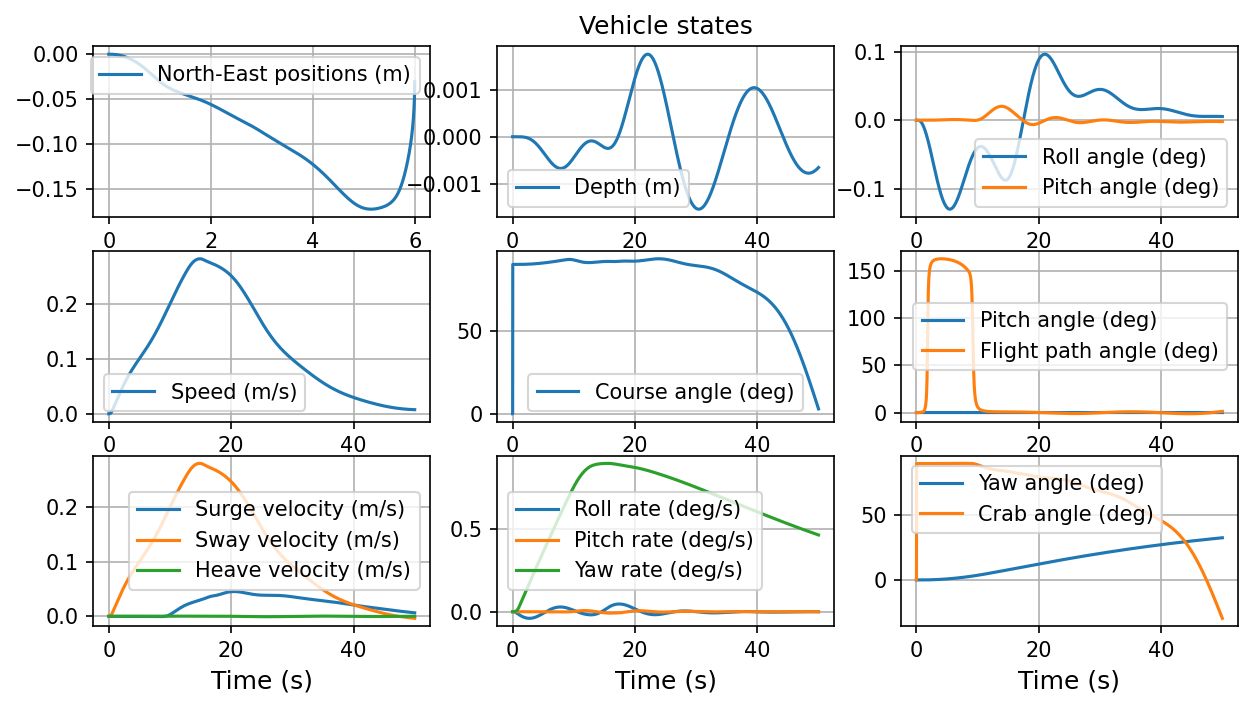

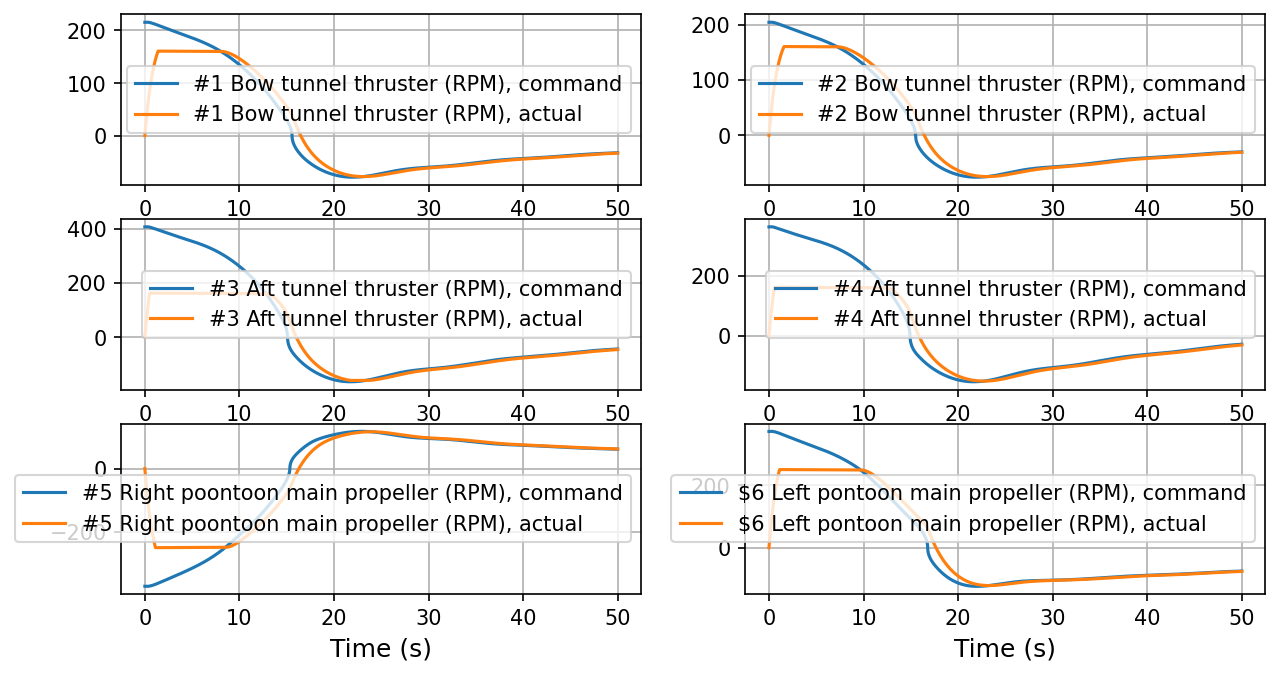

In [131]:
plotVehicleStates(simTime, simData, 1)                    
plotControls(simTime, simData, vehicle, 2)

In [132]:
numDataPoints = 5                 # number of 3D data points
FPS = 10                            # frames per second (animated GIF)
filename = '3D_animation.gif'       # data file for animated GIF
browser = 'safari'       

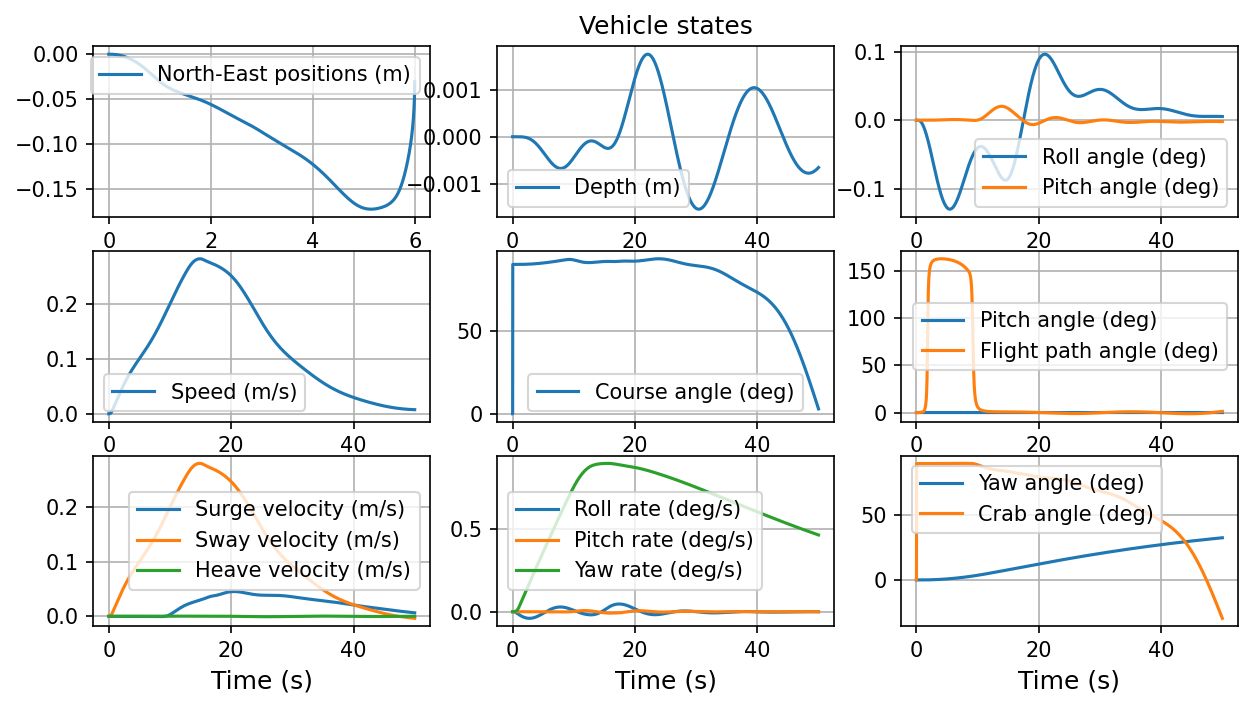

In [133]:
plotVehicleStates(simTime, simData, 3)

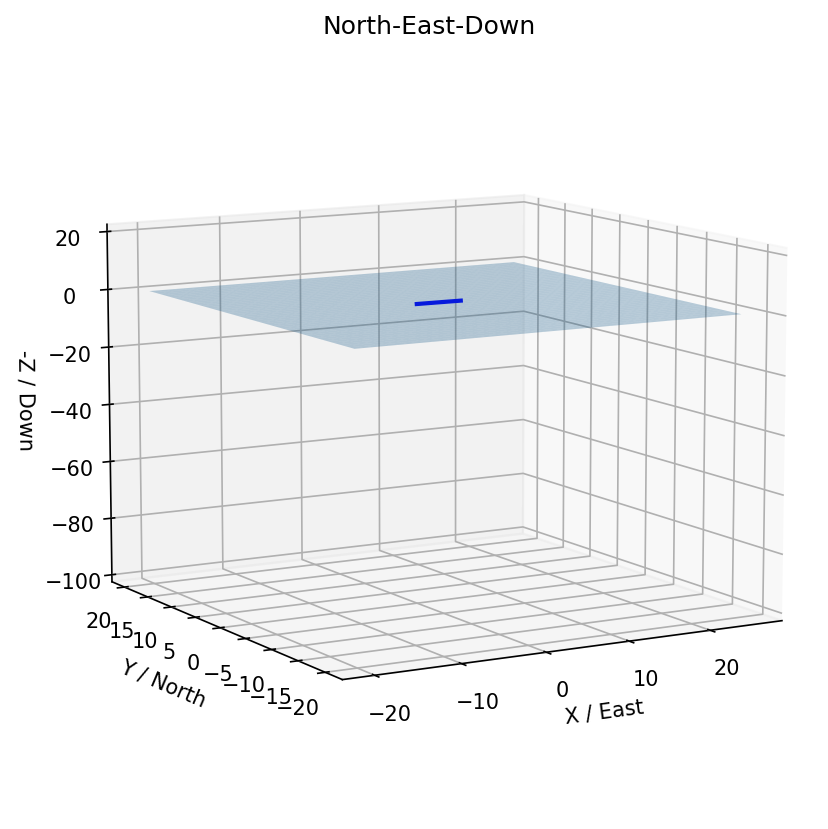

In [134]:
plot3D(simData, numDataPoints, FPS, filename, 3)  

In [135]:
def myDPcontrol(self, eta, nu, sampleTime):
        """
        u = DPcontrol(eta,nu,sampleTime) is a nonlinear PID controller
        for DP based on pole placement:

        tau = -R' Kp (eta-r) - R' Kd R nu - R' Ki int(eta-r)
        u = B_pseudoinverse * tau
        """
        # 3-DOF state vectors
        eta3 = np.array([eta[0], eta[1], eta[5]])
        nu3 = np.array([nu[0], nu[1], nu[5]])

        # 3-DOF diagonal model matrices
        M3 = np.diag([self.M[0][0], self.M[1][1], self.M[5][5]])
        D3 = np.diag([self.D[0][0], self.D[1][1], self.D[5][5]])

        [tau3, self.e_int, self.x_d, self.y_d, self.psi_d] = DPpolePlacement(
            self.e_int,
            M3,
            D3,
            eta3,
            nu3,
            self.x_d,
            self.y_d,
            self.psi_d,
            self.wn,
            self.zeta,
            self.ref,
            sampleTime,
        )
        
        tau=list(tau3)+[tau3[2]*ly - tau3[1]*lz,
                  tau3[0]*lz - tau3[2]*lx,
                  tau3[1]*lx - tau3[0]*ly]

#         u_alloc = self.controlAllocation(tau3)
        return tau

In [136]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [137]:
# Ws[0]*Ret[2]

In [138]:
# np.einsum('i,ijk->ijk',[Ws[i] for i in range(node_N)],Ret)

In [139]:
idx=5/0.01

In [140]:
idx

500.0

In [141]:
ssa(simData[:, 3][int(idx)])

-0.0022313638346709297

In [142]:
ssa(simData[:, 4][int(idx)])

1.3587337935216937e-05

In [143]:
ssa(simData[:, 5][int(idx)])

0.013664356620045393

### Dynamics

In [144]:
def grayscott1d(t, Q): # here
#     print(t)
      
    x,y,z=Q[0:node_N],Q[2*node_N:3*node_N],Q[4*node_N:5*node_N]
    
    idx = find_nearest(np.array(ans_t),  t+5) 

    x_ve = simData[:, 0][idx]
    y_ve = simData[:, 1][idx]
#     x_ve = simData[:, 1][idx]
#     y_ve = simData[:, 0][idx]
    z_ve = simData[:, 2][idx]
    phi_ve = ssa(simData[:, 3][idx])
    theta_ve = ssa(simData[:, 4][idx])
    psi_v = ssa(simData[:, 5][idx])
    
    
    u_ve = simData[:, 6][idx]
    v_ve = simData[:, 7][idx]
#     u_ve = simData[:, 7][idx]
#     v_ve = simData[:, 6][idx]
    w_ve = simData[:, 8][idx]
    p_ve = simData[:, 9][idx]
    q_ve = simData[:, 10][idx]
    r_ve = simData[:, 11][idx]
    
    
    η=np.array([x_ve, y_ve, z_ve, phi_ve, theta_ve, psi_v])
    
    dη=np.array([u_ve, v_ve, w_ve, p_ve, q_ve, r_ve])
    
    
#     n_ = vehicle.DPcontrol(η,dη,sampleTime) # /1e3
    n_ = myDPcontrol(vehicle,η,dη,sampleTime)
#     print(n_)
    

    dx,dy,dz=Q[1*node_N:2*node_N],Q[3*node_N:4*node_N],Q[5*node_N:6*node_N]
    

    φ,θ,ψ=Q[6*node_N:7*node_N],Q[8*node_N:9*node_N],Q[10*node_N:11*node_N]
#     φ[-1],θ[-1],ψ[-1]=phi_ve, theta_ve,psi_v
    Ret = Re_t(φ,θ,ψ)
#     print(Ret)

    dφ,dθ,dψ=Q[7*node_N:8*node_N],Q[9*node_N:10*node_N],Q[11*node_N:12*node_N]
    
#     force_schedule =1/(1+np.exp(-np.exp(t/10)+np.exp(2)))
#     force_schedule = t/15 if t<15 else 1
#     force_schedule = 1e-1000
#     force_schedule=100
    force_schedule=1
#     force_schedule=0
#     print(type(n_))
    tau_force = force_schedule*np.array(n_) # [N]
#     tau_force[0]=0
#     tau_force[1]=0
#     tau_force[2]=0
#     tau_force[3]=0
#     tau_force[4]=0
#     tau_force[5]=0

#     print(tau_force[:3])
    Z0=-np.dot(Re_b(Ret),tau_force[:3])
#     print(Ret)
#     print(Z0)
#     print(Z0)
    Z1 =d_s(ne, x, y, z, Ret,  ωe(φ,θ,ψ,None,None,None)).T
#     Z1 =d_s(ne, x, y, z, Ret, phi(x,y,z,Ret,None)).T
#     print(Z1)
    Z2=ne_(dx,dy,dz,DT,Ret).T
#     print(Z0)

    Z= (Z1 + Z2 +Z0
       )
#     Z[-1]+=tau_force[:3]

############################################################    
#     print(Ws)
    RRRR=Re_b(Ret)
#     print(Ret)
    ddx,ddy, ddz = np.linalg.solve(np.einsum('i,ijk->ijk',
                                             [Ws[i] for i in range(node_N)]
#                                              +[Ws[-1] + vessel_mass]
#                                              M_totl
                                          
                                             ,RRRR),
                                   Z
                                  ).T 
#     print(ddx)
#     print(np.concatenate([ddx, ddy,ddz, dφ,], axis=0))
#     ddx,ddy, ddz = Ret
    ddx,ddy, ddz = np.einsum('ijk,ik->ij',Ret, np.stack([ddx, ddy,ddz], axis=0).T).T
#     print(ddx)
#     print()
############################################################      

    sum_0123=0
    lll=[]
    for i in range(1,len(z0)):
        sum_0123=math.sqrt((x[i]-x[i-1])**2+(y[i]-y[i-1])**2+(z[i]-z[i-1])**2)
        lll.append(sum_0123)
#     print(lll)    
        
    cum_d_inv=[0]
    sum_=0
    for i in range(len(lll)-1,-1,-1):
        sum_+=lll[i]
        cum_d_inv.append(sum_)
    cum_d_inv=cum_d_inv[::-1]   
    
    Irho=inert(mn, vessel_inertia, Irho_, cum_d_inv, Ws)
#     print(Irho)
#     print()
 
    
 

    C1=np.einsum('ijk,ik->ij', Irho_e(Ret,Irho).astype(np.float64),
                                                        np.einsum('ijk,ik->ij', Π(dφ,dθ,dψ).astype(np.float64), 
                                                                  np.array([dφ,dθ,dψ]).astype(np.float64).T))
    
    test=np.einsum('ijk,ik->ij',Π(φ,θ,ψ).astype(np.float64),np.array([dφ,dθ,dψ]).astype(np.float64).T)
  
    C2= np.cross(
         test,
                 np.einsum('ijk,ik->ij',Irho_e(Ret,Irho).astype(np.float64),
                            test))


    C3=d_me(φ,θ,ψ,Ret, ωe, ωe(φ,θ,ψ,None,None,None))
#     print(C3)
    
#     C4= np.cross(d_s(phi,x,y,z,Ret, phi(x,y,z,Ret,None)).T, ne(x,y,z,Ret, phi(x,y,z,Ret,None)))
    C4= np.cross(d_s(phi,x,y,z,Ret, ωe(φ,θ,ψ,None,None,None)).T, 
                 ne(x,y,z,Ret, ωe(φ,θ,ψ,None,None,None),None))
#     print(C4)
#     print(tau_force[:3])
#     C4= np.cross(d_s(phi,x,y,z,Ret, test).T, ne(x,y,z,Ret, test))
    
    K1=test.T

    C5= np.einsum('ijk,ik->ij',Ret, -np.dot(DR,K1).astype(np.float64).T)

    C0=-np.einsum('ijk,kp->ijp',np.einsum('ijk,ikr->ijr',np.linalg.inv(Π(φ,θ,ψ).astype(np.float64)),
                        Re_b(Ret)),tau_force[3:].reshape(3,1)) 
    B_ =(
        -C1
        -C2
        +C3
        +C4
        +C5
    )
    B= B_ +C0.squeeze()
#     print(C0,C1,C2,C3,C4)



#     print(B)   
    
#     print(Irho_e(Ret,Irho))
    A2 = Irho_e(Ret,Irho).astype(np.float64)
    A3=Π(φ,θ,ψ).astype(np.float64)

    A=np.einsum('ijk,ikr->ijr',A2,A3)
    

#     hack=1e18
    hack=1
############################################
    ddφ,ddθ,ddψ = np.linalg.solve(hack*A,B).T
#############################################


#     ddx[0],ddy[0],ddz[0],ddφ[0],ddθ[0],ddψ[0]=0,0,0,0,0,0
    A1111=np.concatenate([dx, ddx, dy, ddy, dz, ddz, dφ, ddφ, dθ, ddθ, dψ, ddψ], axis=0)
#     print(A1111)
    return A1111

In [145]:
# import scipy

In [146]:
# ode15s = scipy.integrate.ode(grayscott1d)
# ode15s.set_integrator('vode', method='bdf', order=15, nsteps=3000)
# # ode15s.set_integrator('vode',  order=32, nsteps=3000)
# ode15s.set_initial_value(q0, 0)

In [147]:
# us=ode15s.integrate(10)

In [148]:
tspan = (0., 0.05)

In [149]:
startTime1 = datetime.now()

us=solve_ivp(grayscott1d,  tspan, q0, 
#              nfev=842
#              method='LSODA',
#              method= 'BDF'
#              vectorized=True
#              min_step=1e-6
#              rtol=1e9, atol=1e9
            )
print(datetime.now() - startTime1)

0:02:39.018082


In [150]:
# key takeaway: one can calibrate the model by tuning bc(init) and force_schedule 

### Results

In [151]:
fin=us

In [152]:
fin

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 10280
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 1.14724471e-10, 1.19675114e-09, ...,
       4.99797813e-02, 4.99910682e-02, 5.00000000e-02])
 t_events: None
        y: array([[ 0.00000000e+00, -1.23564360e-18, -1.34517609e-16, ...,
        -1.92678390e-01, -1.92753520e-01, -1.92812984e-01],
       [ 2.25564997e+02,  2.25564997e+02,  2.25564997e+02, ...,
         2.24911278e+02,  2.24911100e+02,  2.24910959e+02],
       [ 4.51129994e+02,  4.51129994e+02,  4.51129994e+02, ...,
         4.49689179e+02,  4.49688812e+02,  4.49688522e+02],
       ...,
       [ 0.00000000e+00,  4.48766412e-09,  4.68131735e-08, ...,
         5.13185810e+00,  5.13487768e+00,  5.13726837e+00],
       [ 0.00000000e+00,  4.69438531e-09,  4.89695908e-08, ...,
         5.47196486e+00,  5.47521249e+00,  5.47778375e+00],
       [ 0.00000000e+00,  4.89482786e-09,  5

In [153]:
t=fin.t

In [154]:
fin=fin.y.T

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  


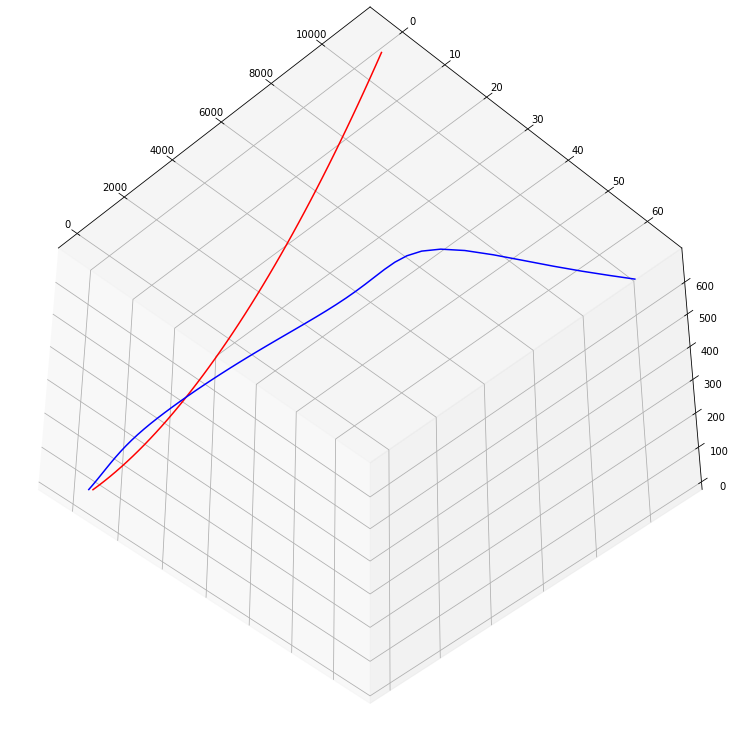

In [155]:
fig=plt.figure(figsize=(13,13))
ax = fig.gca(projection='3d')

X0=fin[0,[i for i in range(0,node_N)]]
Y0=fin[0,[i for i in range(2*node_N,3*node_N)]]
Z0=fin[0,[i for i in range(4*node_N,5*node_N)]]

j=-1
X=fin[j,[i for i in range(0,node_N)]]
Y=fin[j,[i for i in range(2*node_N,3*node_N)]]
Z=fin[j,[i for i in range(4*node_N,5*node_N)]]

num_true_pts = 200
tck, u = interpolate.splprep([X,Y,Z], s=2)
u_fine = np.linspace(0,1,num_true_pts)
x_fine, y_fine, z_fine = interpolate.splev(u_fine, tck)


ax.plot(X0,Y0,Z0, color='r')
ax.plot(X,Y,Z, color='b') 
# ax.plot(x_fine, y_fine, z_fine, color='b')
ax.view_init(-45,-45)

# ax.view_init(0,-90)
plt.show()

In [156]:
X,Y,Z

(array([-1.92812984e-01,  2.24910959e+02,  4.49688522e+02,  6.74250150e+02,
         8.98622524e+02,  1.12281673e+03,  1.34683802e+03,  1.57068869e+03,
         1.79436918e+03,  2.01787869e+03,  2.24121553e+03,  2.46437728e+03,
         2.68736096e+03,  2.91016309e+03,  3.13277974e+03,  3.35520660e+03,
         3.57743895e+03,  3.79947171e+03,  4.02129936e+03,  4.24291600e+03,
         4.46431522e+03,  4.68549009e+03,  4.90643307e+03,  5.12713586e+03,
         5.34758928e+03,  5.56778304e+03,  5.78770544e+03,  6.00734302e+03,
         6.22668006e+03,  6.44569789e+03,  6.66437399e+03,  6.88268087e+03,
         7.10058447e+03,  7.31804229e+03,  7.53500098e+03,  7.75139380e+03,
         7.96713822e+03,  8.18213496e+03,  8.39627060e+03,  8.60942730e+03,
         8.82150408e+03,  9.03245206e+03,  9.24231873e+03,  9.45128276e+03,
         9.65965014e+03,  9.86779125e+03,  1.00760328e+04,  1.02845536e+04,
         1.04933319e+04,  1.07021563e+04]),
 array([-8.80972542e-01, -1.16571874e+00, -1

In [157]:
X0,Y0,Z0

(array([    0.        ,   225.56499683,   451.12999365,   676.69499048,
          902.2599873 ,  1127.82498413,  1353.38998095,  1578.95497778,
         1804.51997461,  2030.08497143,  2255.64996826,  2481.21496508,
         2706.77996191,  2932.34495873,  3157.90995556,  3383.47495239,
         3609.03994921,  3834.60494604,  4060.16994286,  4285.73493969,
         4511.29993651,  4736.86493334,  4962.42993017,  5187.99492699,
         5413.55992382,  5639.12492064,  5864.68991747,  6090.2549143 ,
         6315.81991112,  6541.38490795,  6766.94990477,  6992.5149016 ,
         7218.07989842,  7443.64489525,  7669.20989208,  7894.7748889 ,
         8120.33988573,  8345.90488255,  8571.46987938,  8797.0348762 ,
         9022.59987303,  9248.16486986,  9473.72986668,  9699.29486351,
         9924.85986033, 10150.42485716, 10375.98985398, 10601.55485081,
        10827.11984764, 11052.68484446]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0.

In [158]:
us=fin.T

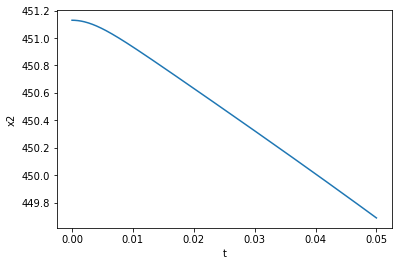

In [159]:
plt.plot(t,us.T[:,2],'-')
plt.xlabel('t')
plt.ylabel('x2')
plt.show()

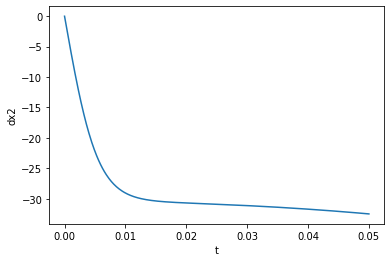

In [160]:
plt.plot(t,us.T[:,node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dx2')
plt.show()

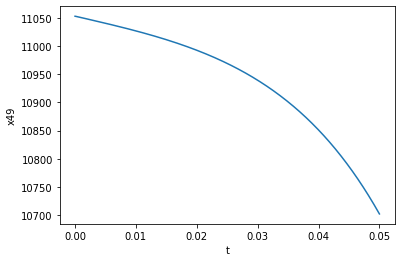

In [161]:
plt.plot(t,us.T[:,node_N-1] ,'-')
plt.xlabel('t')
plt.ylabel('x49')
plt.show()

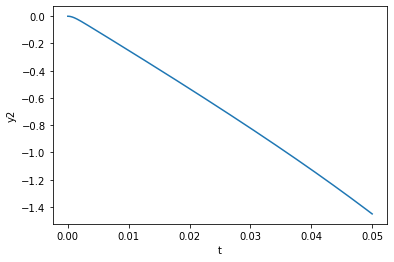

In [162]:
plt.plot(t,us.T[:,2*node_N +2] ,'-')
plt.xlabel('t')
plt.ylabel('y2')
plt.show()

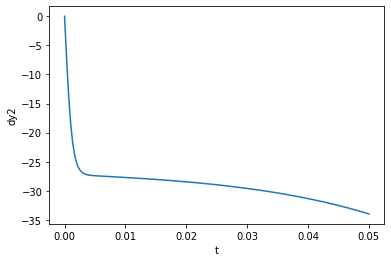

In [163]:
plt.plot(t,us.T[:,3*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dy2')
plt.show()

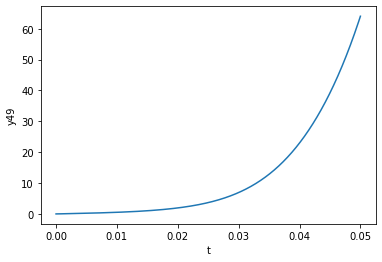

In [164]:
plt.plot(t,us.T[:,2*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('y49')
plt.show()

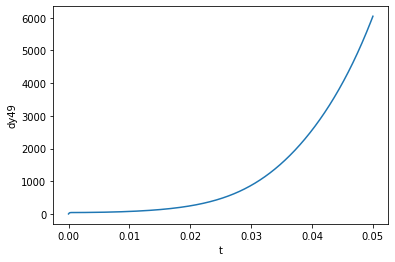

In [165]:
plt.plot(t,us.T[:,3*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('dy49')
plt.show()

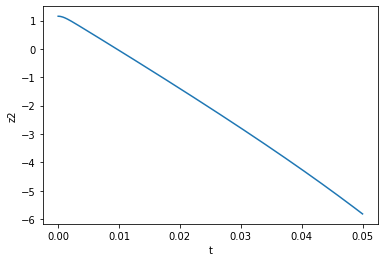

In [166]:
plt.plot(t,us.T[:,4*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('z2')
plt.show()

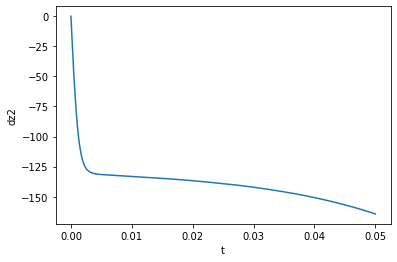

In [167]:
plt.plot(t,us.T[:,5*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dz2')
plt.show()

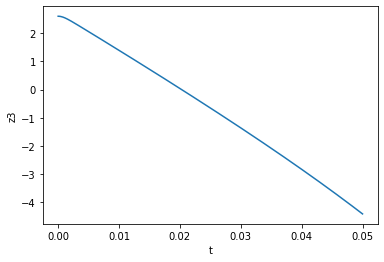

In [168]:
plt.plot(t,us.T[:,4*node_N+3] ,'-')
plt.xlabel('t')
plt.ylabel('z3')
plt.show()

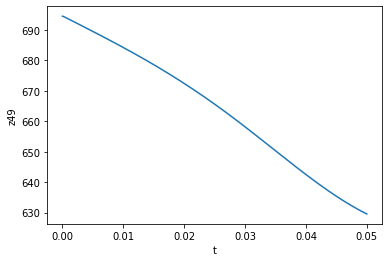

In [169]:
plt.plot(t,us.T[:,4*node_N+49] ,'-')
plt.xlabel('t')
plt.ylabel('z49')
plt.show()

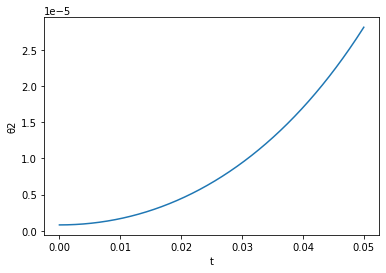

In [170]:
plt.plot(t,us.T[:,8*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('θ2')
plt.show()

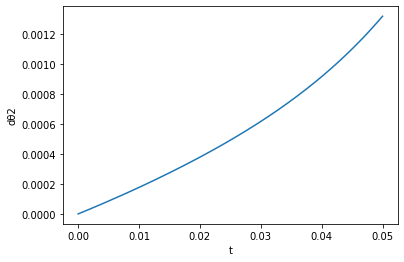

In [171]:
plt.plot(t,us.T[:,9*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dθ2')
plt.show()

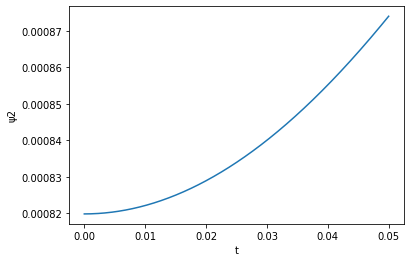

In [172]:
plt.plot(t,us.T[:,10*node_N+2],'-')
plt.xlabel('t')
plt.ylabel('ψ2')
plt.show()

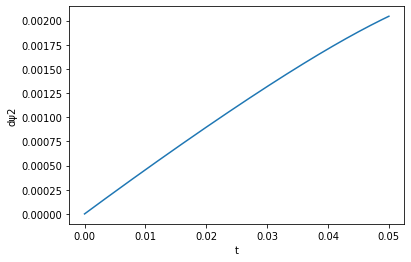

In [173]:
plt.plot(t,us.T[:,11*node_N+2] ,'-')
plt.xlabel('t')
plt.ylabel('dψ2')
plt.show()